# LightGBM

Microsoftが開発したGBDT(勾配ブースティング決定木)のモデル 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fuyu-quant/data-science-wiki/blob/main/tabledata/regression/LightGBM.ipynb)

In [ ]:
!pip install lightgbm==4.0.0

In [10]:
import lightgbm as lgb

import pandas as pd
from sklearn.datasets import fetch_california_housing

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings   
warnings.filterwarnings('ignore')
import sklearn.datasets as skd
from sklearn.model_selection import train_test_split


#### データセットの用意

In [9]:
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['target'] = pd.Series(california.target, name='MedHouseVal')
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### LightGBMの学習




In [23]:
#訓練データと評価用データを用意する
x_train,x_valid,y_train,y_valid = train_test_split(x,y,test_size = 0.2, random_state=4)

#カテゴリー変数を設定(カテゴリカル変数がある場合はそのリストを作る)
categorical_features = []



#LightGBM用の訓練データセットを作成
lgb_train = lgb.Dataset(x_train,y_train,categorical_feature=categorical_features,free_raw_data=False)

#LightGBM用の評価データセットを作成
lgb_eval = lgb.Dataset(x_valid,y_valid,reference=lgb_train,categorical_feature=categorical_features,free_raw_data=False)


#ハイパーパラメータを設定
params = {
    'boosting_type': 'gbdt',

    #'objective': 'binary', 二値分類
    'objective': 'regression', #回帰
    
    #'metric':'auc'　AUCの最大化を目指す
    'metric': {'l2', 'l1'}, 

    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'vervose': 0
    
}

#LightGBMの学習
lgbm_model = lgbm.train(params,lgb_train,
                 valid_sets=[lgb_train,lgb_eval],
                 verbose_eval=10,
                 num_boost_round=1000,
                 early_stopping_rounds= 20)

#最もスコアの良いモデルの保存
optimum_boost_rounds = lgbm_model.best_iteration

#LightGBMの予測
y_pred = lgbm_model.predict(x_valid,num_interation=lgbm_model.best_iteration)

Training until validation scores don't improve for 20 rounds.
[10]	training's l1: 4.46428	training's l2: 39.9574	valid_1's l1: 4.84233	valid_1's l2: 49.4685
[20]	training's l1: 3.31764	training's l2: 23.8964	valid_1's l1: 3.64069	valid_1's l2: 32.715
[30]	training's l1: 2.64532	training's l2: 15.693	valid_1's l1: 2.94572	valid_1's l2: 22.5831
[40]	training's l1: 2.28	training's l2: 11.8877	valid_1's l1: 2.60715	valid_1's l2: 18.4168
[50]	training's l1: 2.03456	training's l2: 9.7851	valid_1's l1: 2.36737	valid_1's l2: 16.1922
[60]	training's l1: 1.85772	training's l2: 8.3846	valid_1's l1: 2.24571	valid_1's l2: 14.676
[70]	training's l1: 1.7303	training's l2: 7.4965	valid_1's l1: 2.23686	valid_1's l2: 14.5642
[80]	training's l1: 1.63064	training's l2: 6.71586	valid_1's l1: 2.22736	valid_1's l2: 14.0676
[90]	training's l1: 1.55637	training's l2: 6.12467	valid_1's l1: 2.18966	valid_1's l2: 13.3808
[100]	training's l1: 1.50507	training's l2: 5.68258	valid_1's l1: 2.19623	valid_1's l2: 13.05

#### 特徴量重要度
* 特徴量重要度の算出には二つの方法がある
* 「出現頻度」による重要度
* 「目的関数の減少量」による重要度
* 特徴量可視化ツールの説明(https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html)

In [36]:
#特徴量重要度の可視化
importance = pd.DataFrame(lgbm_model.feature_importance(importance_type = 'split'),index = x.columns,columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance)

,importance
RM,166
LSTAT,151
DIS,133
AGE,115
CRIM,111
NOX,99
B,82
PTRATIO,70
TAX,64
RAD,31


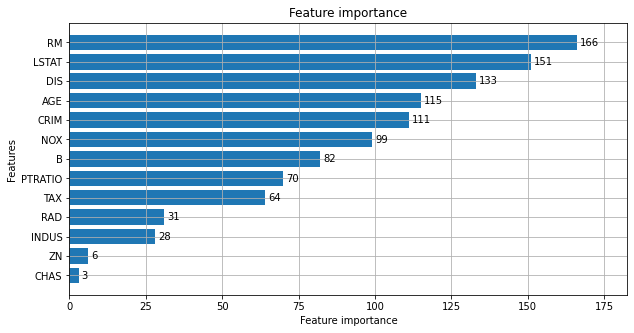

In [38]:
#可視化
lgb.plot_importance(lgbm_model, height = 0.8 ,figsize = (10,5),importance_type='split',)
plt.show()

In [32]:
#目的関数の減少量による重要度
importance = pd.DataFrame(lgbm_model.feature_importance(importance_type = 'gain'),index = x.columns,columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance)

,importance
RM,125310.421387
LSTAT,81054.687753
NOX,11187.428839
CRIM,10424.249169
DIS,9326.319862
PTRATIO,7042.769119
AGE,6832.982699
TAX,3662.494845
B,2128.183310
INDUS,1539.570608


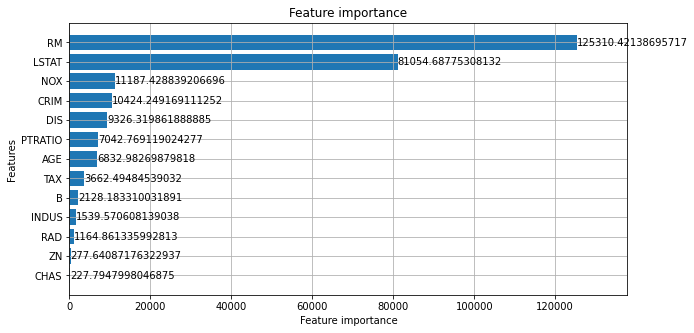

In [37]:
#可視化
lgb.plot_importance(lgbm_model, height = 0.8 ,figsize = (10,5),importance_type='gain',)
plt.show()

## 勾配ブースティング決定木の可視化


In [40]:
!pip install dtreeviz

     |████████████████████████████████| 62 kB 610 kB/s eta 0:00:011
  Created wheel for dtreeviz: filename=dtreeviz-1.3.2-py3-none-any.whl size=67935 sha256=f992d4355804fdeee6dda1c1cf1d1f40577a6a9216baf95d7194619e1e27b5ca
  Stored in directory: /root/.cache/pip/wheels/9d/29/a1/f2ad20de79875e749330d5c6234fc5f517991fcaa23d7a3d0f
Successfully built dtreeviz


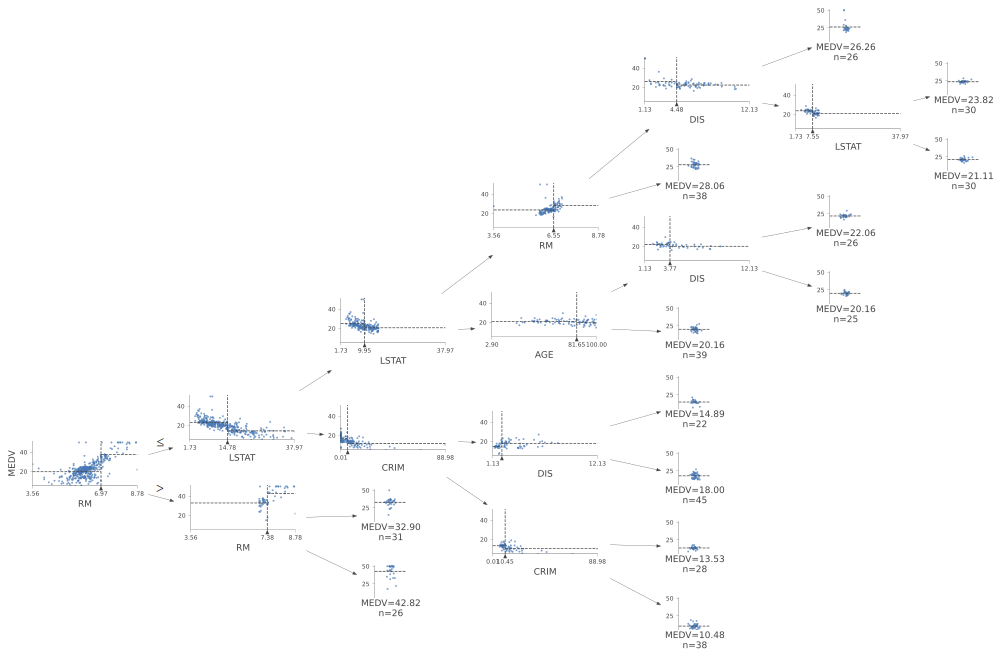

In [45]:
from dtreeviz.trees import *

viz = dtreeviz(lgbm_model,
               x_data = x_train,
               y_data = y_train,
               target_name = 'MEDV',     #目的変数の名前(今回はボストン住宅データの目的変数の名前)
               feature_names = x_train.columns.tolist(),
              orientation='LR',     #決定木を横向きで表示する
              tree_index = 0)

viz

## クロスバリデーションverの学習

In [52]:
#KFoldでは分類問題のクラスラベルが均等に分類される
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


#カテゴリー変数を設定(カテゴリカル変数がある場合はそのリストを作る)
categorical_features = ['CHAS']


#モデルを保存するリスト
models = []
#精度のスコアを保存するリスト
r2_scores = []

#KFoldクラスをインスタンス化
#K_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
K_fold = KFold(n_splits=5, shuffle=True, random_state=1)


#クロスバリデーションをする
for fold, (train_index, valid_index) in enumerate(K_fold.split(x,y)):

  #ilocはDataFrameやSeriesじゃないと使えないから注意!
  x_train = x.iloc[train_index]
  x_valid = x.iloc[valid_index]
  y_train = y.iloc[train_index]
  y_valid = y.iloc[valid_index]

  #LightGBM用の訓練データセットを作成
  lgb_train = lgb.Dataset(x_train,y_train,categorical_feature=categorical_features,free_raw_data=False)

  #LightGBM用の評価データセットを作成
  lgb_eval = lgb.Dataset(x_valid,y_valid,reference=lgb_train,categorical_feature=categorical_features,free_raw_data=False)


  #ハイパーパラメータを設定
  params = {
    'boosting_type': 'gbdt',

    #'objective': 'binary', 二値分類
    'objective': 'regression', #回帰
    
    #'metric':'auc'　AUCの最大化を目指す
    'metric': {'l2', 'l1'}, 

    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'vervose': 0
    
  }

  #LightGBMの学習
  lgbm_model = lgb.train(params,lgb_train,
                 valid_sets=[lgb_train,lgb_eval],
                 verbose_eval=10,
                 num_boost_round=1000,
                 early_stopping_rounds= 20)
  

  #LightGBMの予測
  y_pred = lgbm_model.predict(x_valid,num_interation=lgbm_model.best_iteration)


  #r2_scoreで評価(決定係数によるモデルの当てはまりの良さを評価)
  score = r2_score(y_valid,y_pred)
  
  r2_scores.append(score)
  models.append(lgbm_model)

Training until validation scores don't improve for 20 rounds.
[10]	training's l1: 4.4177	training's l2: 39.0739	valid_1's l1: 5.02345	valid_1's l2: 50.1709
[20]	training's l1: 3.24215	training's l2: 23.5141	valid_1's l1: 3.91174	valid_1's l2: 30.1944
[30]	training's l1: 2.57326	training's l2: 16.7798	valid_1's l1: 3.39827	valid_1's l2: 22.5283
[40]	training's l1: 2.18722	training's l2: 12.8693	valid_1's l1: 3.01721	valid_1's l2: 17.3421
[50]	training's l1: 1.90035	training's l2: 10.4885	valid_1's l1: 2.77648	valid_1's l2: 14.1668
[60]	training's l1: 1.74942	training's l2: 9.28796	valid_1's l1: 2.6286	valid_1's l2: 12.667
[70]	training's l1: 1.65417	training's l2: 8.48276	valid_1's l1: 2.53314	valid_1's l2: 11.788
[80]	training's l1: 1.58687	training's l2: 7.69729	valid_1's l1: 2.46774	valid_1's l2: 11.0151
[90]	training's l1: 1.51895	training's l2: 7.07373	valid_1's l1: 2.44682	valid_1's l2: 10.6774
[100]	training's l1: 1.46421	training's l2: 6.74955	valid_1's l1: 2.45199	valid_1's l2:

In [54]:
r2_scores

[0.9033677476902879,
 0.7624792667752438,
 0.928674641101356,
 0.8006808615102574,
 0.8588117548633999]